In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Batch vs. Incremental Training

The algorithm described above is the **stochastic gradient descent** algorithm, which involves **on-line** or **incremental training**. In this type of training, the network's weights and biases are updated after each input is presented (similar to the LMS algorithm of Chapter 10).

However, it is also possible to perform **batch training**, in which the complete gradient is computed after applying all inputs to the network before updating the weights and biases.

### Mean Square Error (MSE) Performance Index

If each input occurs with equal probability, the mean square error performance index is given by:

$$
F(x) = E \left[ e^T e \right] = E \left[ (t - a)^T (t - a) \right] = \frac{1}{Q} \sum_{q=1}^{Q} (t_q - a_q)^T (t_q - a_q)
$$

Where:
- $ t_q $ is the target output for input $ q $,
- $ a_q $ is the actual output of the network.

### Total Gradient of the MSE

The total gradient of this performance index is:

$$
\nabla F(x) = \nabla \left( \frac{1}{Q} \sum_{q=1}^{Q} (t_q - a_q)^T (t_q - a_q) \right) = \frac{1}{Q} \sum_{q=1}^{Q} \nabla \left[ (t_q - a_q)^T (t_q - a_q) \right]
$$

Therefore, the total gradient of the mean square error is the mean of the gradients of the individual squared errors.

### Batch Gradient Descent Update Equations

In batch training, the update equations for the batch steepest descent algorithm are:

For the weight update:

$$
W^{(m)}(k + 1) = W^{(m)}(k) - \frac{\alpha^{(m)}}{Q} \sum_{q=1}^{Q} s_q^{(m)} \left( a_q^{(m)} \right)^T
$$

For the bias update:

$$
b^{(m)}(k + 1) = b^{(m)}(k) - \frac{\alpha^{(m)}}{Q} \sum_{q=1}^{Q} s_q^{(m)}
$$

Where:
- $ W^{(m)} $ represents the weight matrix for layer $ m $,
- $ b^{(m)} $ is the bias vector for layer $ m $,
- $ \alpha^{(m)} $ is the learning rate for layer $ m $,
- $ s_q^{(m)} $ is the sensitivity for input $ q $ at layer $ m $,
- $ a_q^{(m)} $ is the activation of input $ q $ at layer $ m $,
- $ Q $ is the number of training examples.


In [1]:
import random
import math

# Helper functions
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def mean_square_error(target, output):
    return (target - output) ** 2

# Feedforward Network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases for a 2-layer neural network
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Initialize weights and biases with small random values
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(input_size)] for _ in range(hidden_size)]
        self.weights_hidden_output = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_output = random.uniform(-1, 1)

    def feedforward(self, inputs):
        # Compute hidden layer activations
        self.hidden_layer = []
        for i in range(self.hidden_size):
            hidden_input = sum([self.weights_input_hidden[i][j] * inputs[j] for j in range(self.input_size)]) + self.bias_hidden[i]
            self.hidden_layer.append(sigmoid(hidden_input))
        
        # Compute output
        output = sum([self.hidden_layer[i] * self.weights_hidden_output[i] for i in range(self.hidden_size)]) + self.bias_output
        return sigmoid(output)
    
    def backpropagate(self, inputs, target, learning_rate):
        # Feedforward
        output = self.feedforward(inputs)

        # Compute output error and gradient
        output_error = target - output
        output_gradient = output_error * sigmoid_derivative(output)

        # Update hidden-output weights and bias
        for i in range(self.hidden_size):
            self.weights_hidden_output[i] += learning_rate * output_gradient * self.hidden_layer[i]
        self.bias_output += learning_rate * output_gradient

        # Compute hidden layer errors and update input-hidden weights and biases
        for i in range(self.hidden_size):
            hidden_error = output_gradient * self.weights_hidden_output[i]
            hidden_gradient = hidden_error * sigmoid_derivative(self.hidden_layer[i])
            for j in range(self.input_size):
                self.weights_input_hidden[i][j] += learning_rate * hidden_gradient * inputs[j]
            self.bias_hidden[i] += learning_rate * hidden_gradient
# Incremental training (stochastic gradient descent)
def train_incremental(network, data, learning_rate, epochs):
    for epoch in range(epochs):
        total_loss = 0
        for inputs, target in data:
            output = network.feedforward(inputs)
            total_loss += mean_square_error(target, output)
            network.backpropagate(inputs, target, learning_rate)
        yield total_loss / len(data)  # Yield loss per epoch for plotting

# Batch training (batch gradient descent)
def train_batch(network, data, learning_rate, epochs):
    for epoch in range(epochs):
        total_loss = 0
        weight_input_hidden_deltas = [[0 for _ in range(network.input_size)] for _ in range(network.hidden_size)]
        weight_hidden_output_deltas = [0 for _ in range(network.hidden_size)]
        bias_hidden_deltas = [0 for _ in range(network.hidden_size)]
        bias_output_delta = 0

        # Accumulate gradients over the entire batch
        for inputs, target in data:
            output = network.feedforward(inputs)
            total_loss += mean_square_error(target, output)

            # Compute gradients for current sample
            output_error = target - output
            output_gradient = output_error * sigmoid_derivative(output)
            for i in range(network.hidden_size):
                weight_hidden_output_deltas[i] += output_gradient * network.hidden_layer[i]
            bias_output_delta += output_gradient

            for i in range(network.hidden_size):
                hidden_error = output_gradient * network.weights_hidden_output[i]
                hidden_gradient = hidden_error * sigmoid_derivative(network.hidden_layer[i])
                for j in range(network.input_size):
                    weight_input_hidden_deltas[i][j] += hidden_gradient * inputs[j]
                bias_hidden_deltas[i] += hidden_gradient

        # Update weights and biases using averaged gradients
        for i in range(network.hidden_size):
            for j in range(network.input_size):
                network.weights_input_hidden[i][j] += learning_rate * weight_input_hidden_deltas[i][j] / len(data)
            network.weights_hidden_output[i] += learning_rate * weight_hidden_output_deltas[i] / len(data)
            network.bias_hidden[i] += learning_rate * bias_hidden_deltas[i] / len(data)
        network.bias_output += learning_rate * bias_output_delta / len(data)

        yield total_loss / len(data)  # Yield loss per epoch for plotting
# Simple plotting function
def plot_loss(batch_losses, incremental_losses, epochs):
    print("Epoch\tBatch Loss\tIncremental Loss")
    for i in range(epochs):
        print(f"{i}\t{batch_losses[i]:.6f}\t{incremental_losses[i]:.6f}")

# Generate synthetic dataset (XOR-like problem)
def generate_data():
    return [
        ([0, 0], 0),
        ([0, 1], 1),
        ([1, 0], 1),
        ([1, 1], 0)
    ]

# Initialize networks
network_batch = NeuralNetwork(2, 3, 1)
network_incremental = NeuralNetwork(2, 3, 1)

# Training parameters
epochs = 1000
learning_rate = 0.1
data = generate_data()

# Train both networks and collect loss values
batch_losses = list(train_batch(network_batch, data, learning_rate, epochs))
incremental_losses = list(train_incremental(network_incremental, data, learning_rate, epochs))

# Plot and compare results
plot_loss(batch_losses, incremental_losses, epochs)


Epoch	Batch Loss	Incremental Loss
0	0.249545	0.256524
1	0.249544	0.256365
2	0.249542	0.256218
3	0.249540	0.256082
4	0.249539	0.255958
5	0.249537	0.255843
6	0.249536	0.255737
7	0.249534	0.255639
8	0.249533	0.255549
9	0.249532	0.255466
10	0.249530	0.255390
11	0.249529	0.255319
12	0.249527	0.255254
13	0.249526	0.255194
14	0.249525	0.255139
15	0.249524	0.255087
16	0.249523	0.255040
17	0.249521	0.254997
18	0.249520	0.254956
19	0.249519	0.254919
20	0.249518	0.254885
21	0.249517	0.254853
22	0.249516	0.254823
23	0.249515	0.254796
24	0.249514	0.254771
25	0.249513	0.254747
26	0.249512	0.254726
27	0.249511	0.254706
28	0.249510	0.254687
29	0.249509	0.254670
30	0.249508	0.254653
31	0.249507	0.254638
32	0.249506	0.254624
33	0.249506	0.254611
34	0.249505	0.254599
35	0.249504	0.254588
36	0.249503	0.254577
37	0.249503	0.254567
38	0.249502	0.254558
39	0.249501	0.254549
40	0.249500	0.254541
41	0.249500	0.254533
42	0.249499	0.254526
43	0.249498	0.254519
44	0.249498	0.254513
45	0.249497	0.254506
46	0.24949

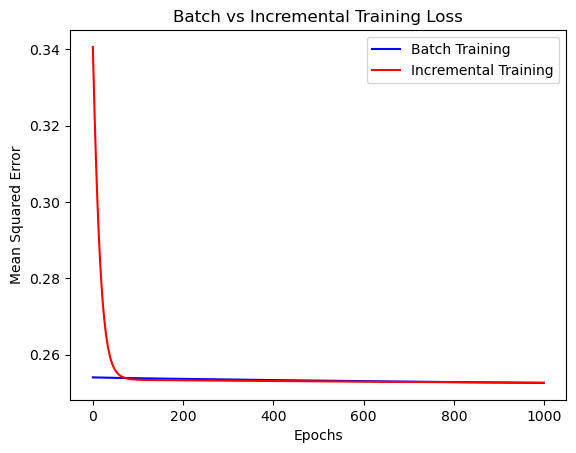

In [2]:
import random
import math
import matplotlib.pyplot as plt

# Helper functions
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def mean_square_error(target, output):
    return (target - output) ** 2

# Feedforward Network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases for a 2-layer neural network
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Initialize weights and biases with small random values
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(input_size)] for _ in range(hidden_size)]
        self.weights_hidden_output = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_output = random.uniform(-1, 1)

    def feedforward(self, inputs):
        # Compute hidden layer activations
        self.hidden_layer = []
        for i in range(self.hidden_size):
            hidden_input = sum([self.weights_input_hidden[i][j] * inputs[j] for j in range(self.input_size)]) + self.bias_hidden[i]
            self.hidden_layer.append(sigmoid(hidden_input))
        
        # Compute output
        output = sum([self.hidden_layer[i] * self.weights_hidden_output[i] for i in range(self.hidden_size)]) + self.bias_output
        return sigmoid(output)
    
    def backpropagate(self, inputs, target, learning_rate):
        # Feedforward
        output = self.feedforward(inputs)

        # Compute output error and gradient
        output_error = target - output
        output_gradient = output_error * sigmoid_derivative(output)

        # Update hidden-output weights and bias
        for i in range(self.hidden_size):
            self.weights_hidden_output[i] += learning_rate * output_gradient * self.hidden_layer[i]
        self.bias_output += learning_rate * output_gradient

        # Compute hidden layer errors and update input-hidden weights and biases
        for i in range(self.hidden_size):
            hidden_error = output_gradient * self.weights_hidden_output[i]
            hidden_gradient = hidden_error * sigmoid_derivative(self.hidden_layer[i])
            for j in range(self.input_size):
                self.weights_input_hidden[i][j] += learning_rate * hidden_gradient * inputs[j]
            self.bias_hidden[i] += learning_rate * hidden_gradient

# Incremental training (stochastic gradient descent)
def train_incremental(network, data, learning_rate, epochs):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, target in data:
            output = network.feedforward(inputs)
            total_loss += mean_square_error(target, output)
            network.backpropagate(inputs, target, learning_rate)
        losses.append(total_loss / len(data))  # Collect loss for plotting
    return losses

# Batch training (batch gradient descent)
def train_batch(network, data, learning_rate, epochs):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        weight_input_hidden_deltas = [[0 for _ in range(network.input_size)] for _ in range(network.hidden_size)]
        weight_hidden_output_deltas = [0 for _ in range(network.hidden_size)]
        bias_hidden_deltas = [0 for _ in range(network.hidden_size)]
        bias_output_delta = 0

        # Accumulate gradients over the entire batch
        for inputs, target in data:
            output = network.feedforward(inputs)
            total_loss += mean_square_error(target, output)

            # Compute gradients for current sample
            output_error = target - output
            output_gradient = output_error * sigmoid_derivative(output)
            for i in range(network.hidden_size):
                weight_hidden_output_deltas[i] += output_gradient * network.hidden_layer[i]
            bias_output_delta += output_gradient

            for i in range(network.hidden_size):
                hidden_error = output_gradient * network.weights_hidden_output[i]
                hidden_gradient = hidden_error * sigmoid_derivative(network.hidden_layer[i])
                for j in range(network.input_size):
                    weight_input_hidden_deltas[i][j] += hidden_gradient * inputs[j]
                bias_hidden_deltas[i] += hidden_gradient

        # Update weights and biases using averaged gradients
        for i in range(network.hidden_size):
            for j in range(network.input_size):
                network.weights_input_hidden[i][j] += learning_rate * weight_input_hidden_deltas[i][j] / len(data)
            network.weights_hidden_output[i] += learning_rate * weight_hidden_output_deltas[i] / len(data)
            network.bias_hidden[i] += learning_rate * bias_hidden_deltas[i] / len(data)
        network.bias_output += learning_rate * bias_output_delta / len(data)

        losses.append(total_loss / len(data))  # Collect loss for plotting
    return losses

# Simple plotting function using matplotlib
def plot_loss(batch_losses, incremental_losses, epochs):
    plt.plot(range(epochs), batch_losses, label="Batch Training", color='blue')
    plt.plot(range(epochs), incremental_losses, label="Incremental Training", color='red')
    plt.title("Batch vs Incremental Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.show()

# Generate synthetic dataset (XOR-like problem)
def generate_data():
    return [
        ([0, 0], 0),
        ([0, 1], 1),
        ([1, 0], 1),
        ([1, 1], 0)
    ]

# Initialize networks
network_batch = NeuralNetwork(2, 3, 1)
network_incremental = NeuralNetwork(2, 3, 1)

# Training parameters
epochs = 1000
learning_rate = 0.1
data = generate_data()

# Train both networks and collect loss values
batch_losses = train_batch(network_batch, data, learning_rate, epochs)
incremental_losses = train_incremental(network_incremental, data, learning_rate, epochs)

# Plot and compare results
plot_loss(batch_losses, incremental_losses, epochs)


## Backpropagation: Practical Implementation Issues

In this section, we will present some issues related to the practical implementation of backpropagation. We will discuss the choice of network architecture, problems with network convergence, and generalization.

### Choice of Network Architecture

As discussed earlier, multilayer networks can approximate almost any function, provided we have enough neurons in the hidden layers. However, it is generally difficult to determine the exact number of layers or neurons required for optimal performance.

### Example 1

Let's assume we want to approximate the following functions:

$$
g(p) = 1 + \sin\left(\frac{i\pi}{4} p\right) \quad \text{for} \quad -2 \leq p \leq 2,
$$

where $i$ takes on the values $1, 2, 4, 8$. As $i$ increases, the function becomes more complex, with more periods of the sine wave over the interval $ -2 \leq p \leq 2 $. It becomes more difficult for a neural network with a fixed number of neurons in the hidden layers to approximate $ g(p) $ as $ i $ increases.

We will use a 1-3-1 network for this example, where:
- The transfer function for the first layer is **log-sigmoid**.
- The transfer function for the second layer is **linear**.

The response of this type of two-layer network can be a sum of three log-sigmoid functions (or as many log-sigmoids as there are neurons in the hidden layer). However, there is a limit to how complex a function this network can approximate.

### Visualization of Network Responses

The figure below illustrates the response of the network after it has been trained to approximate $g(p)$ for $i = 1, 2, 4, 8$. The final network responses are shown by the blue lines.

$$
\begin{aligned}
\text{For } i = 1: & \quad \text{Network accurately approximates the function}. \\
\text{For } i = 4: & \quad \text{The network reaches its maximum capability}. \\
\text{For } i = 8: & \quad \text{The network can only approximate a small part of the function}.
\end{aligned}
$$

### Example 2

In the second example, we pick a single function \(g(p)\) and use larger networks until we accurately represent the function. Here, we choose:

$$
g(p) = 1 + \sin\left(\frac{6\pi}{4} p\right) \quad \text{for} \quad -2 \leq p \leq 2.
$$

We will use two-layer networks, with:
- **log-sigmoid** neurons in the hidden layer.
- **linear** neurons in the output layer.

As discussed earlier, the response of such a network is a superposition of $S$ sigmoid functions. The figure below illustrates the network response as the number of neurons in the hidden layer increases. At least five neurons in the hidden layer are required for the network to accurately represent $g(p)$.

### Summary

A 1-$S$-1 network, with sigmoid neurons in the hidden layer and linear neurons in the output layer, can produce a response that is a superposition of $S$ sigmoid functions. To approximate a function with many inflection points, a larger number of neurons in the hidden layer is required.

Use the MATLAB® Neural Network Design Demonstration (nnd11fa) to gain more insight into the capability of a two-layer network.


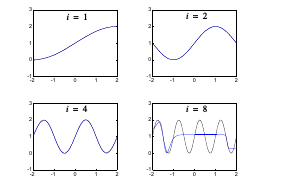

Figure.10 Function Approximation Using a 1-3-1 Network

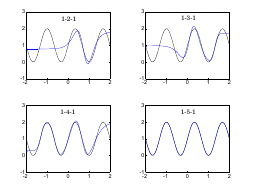

Figure.11 Effect of Increasing the Number of Hidden Neurons

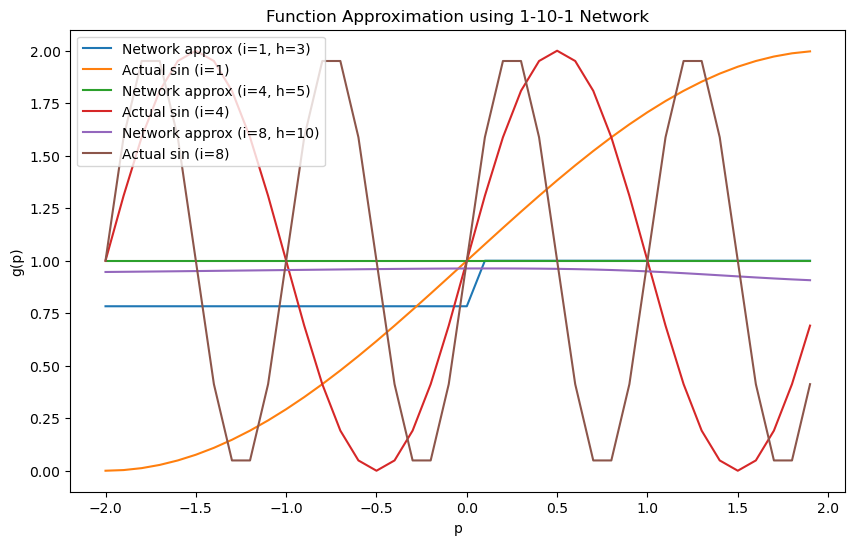

In [5]:
import matplotlib.pyplot as plt
import math
import random

# Sigmoid activation function with clipping to avoid overflow
def sigmoid(x):
    # Clip the input to prevent overflow in math.exp
    if x < -700:  # Any number less than this will cause math.exp to overflow
        x = -700
    if x > 700:   # Likewise for very large positive numbers
        x = 700
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with random values
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Weights and biases
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_output = random.uniform(-1, 1)

    # Feedforward
    def forward(self, inputs):
        # Calculate hidden layer activations
        self.hidden_layer_output = []
        for i in range(self.hidden_size):
            hidden_input = sum([inputs[j] * self.weights_input_hidden[j][i] for j in range(self.input_size)]) + self.bias_hidden[i]
            self.hidden_layer_output.append(sigmoid(hidden_input))
        
        # Calculate output layer activations
        output_input = sum([self.hidden_layer_output[i] * self.weights_hidden_output[i] for i in range(self.hidden_size)]) + self.bias_output
        output = sigmoid(output_input)
        return output

    # Backpropagation
    def train(self, inputs, target, learning_rate=0.1):
        output = self.forward(inputs)
        # Output layer error
        output_error = target - output
        output_delta = output_error * sigmoid_derivative(output)
        
        # Update weights and biases for hidden-output layer
        for i in range(self.hidden_size):
            self.weights_hidden_output[i] += learning_rate * output_delta * self.hidden_layer_output[i]
        self.bias_output += learning_rate * output_delta
        
        # Hidden layer error
        hidden_error = [self.weights_hidden_output[i] * output_delta for i in range(self.hidden_size)]
        hidden_delta = [hidden_error[i] * sigmoid_derivative(self.hidden_layer_output[i]) for i in range(self.hidden_size)]
        
        # Update weights and biases for input-hidden layer
        for i in range(self.hidden_size):
            for j in range(self.input_size):
                self.weights_input_hidden[j][i] += learning_rate * hidden_delta[i] * inputs[j]
            self.bias_hidden[i] += learning_rate * hidden_delta[i]

# Function to approximate sin function
def train_and_plot_network(i_value, hidden_size):
    # Define training data for sin function
    p_values = [-2 + 4 * random.random() for _ in range(100)]
    targets = [1 + math.sin(i_value * math.pi * p / 4) for p in p_values]
    
    # Create a neural network with 1 input, hidden_size hidden neurons, and 1 output
    nn = NeuralNetwork(1, hidden_size, 1)
    
    # Train the network
    for epoch in range(1000):  # More epochs for better learning
        for p, t in zip(p_values, targets):
            nn.train([p], t)
    
    # Test the network on the same range of inputs
    test_p_values = [-2 + 0.1 * x for x in range(40)]
    predictions = [nn.forward([p]) for p in test_p_values]
    actual_values = [1 + math.sin(i_value * math.pi * p / 4) for p in test_p_values]
    
    # Plot the results
    plt.plot(test_p_values, predictions, label=f'Network approx (i={i_value}, h={hidden_size})')
    plt.plot(test_p_values, actual_values, label=f'Actual sin (i={i_value})')
    plt.xlabel('p')
    plt.ylabel('g(p)')
    plt.title(f'Function Approximation using 1-{hidden_size}-1 Network')
    plt.legend()

# Train networks with increasing complexity and hidden neurons
plt.figure(figsize=(10, 6))

# Example 1: Simple function (i=1) with 3 hidden neurons
train_and_plot_network(1, 3)

# Example 2: Complex function (i=4) with 5 hidden neurons
train_and_plot_network(4, 5)

# Example 3: More complex function (i=8) with 10 hidden neurons
train_and_plot_network(8, 10)

plt.show()


## Function Approximation and Convergence Issues in Backpropagation

In this section, we illustrate the problem of convergence when using the backpropagation algorithm to train a 1-3-1 network to approximate a function. We aim to approximate the following function:

$$
g(p) = 1 + \sin(\pi p), \quad -2 \leq p \leq 2
$$

### Network Architecture

We are using a 1-3-1 network, where:
- The transfer function for the first layer is **log-sigmoid**.
- The transfer function for the second layer is **linear**.

### Case 1: Convergence to Global Minimum

In some cases, the learning algorithm converges to a solution that minimizes the mean square error. This is shown in Figure.12, where the thin blue lines represent intermediate iterations, and the thick blue line represents the final solution. The numbers indicate the sequence of iterations:

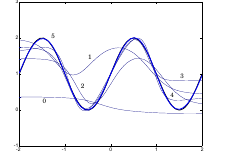

Figure.12 Convergence to a Global Minimum

$$
\text{Iterations: } 0, 1, 2, 3, 4, 5
$$

Here, the algorithm successfully finds the global minimum.

### Case 2: Convergence to Local Minimum

However, in some cases, the algorithm converges to a solution that does not minimize the mean square error. Figure.13 illustrates this problem, where the final solution corresponds to a local minimum, even though a better solution exists.

The only difference between the two cases is the **initial condition**. In one case, the algorithm converged to a global minimum, while in the other, it converged to a local minimum.


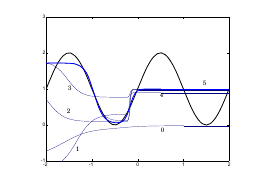

Figure.13 Convergence to a Local Minimum



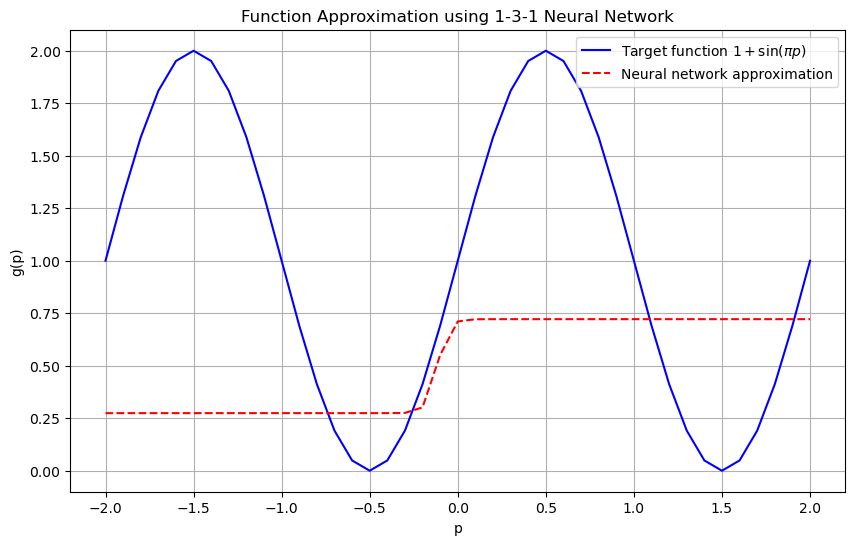

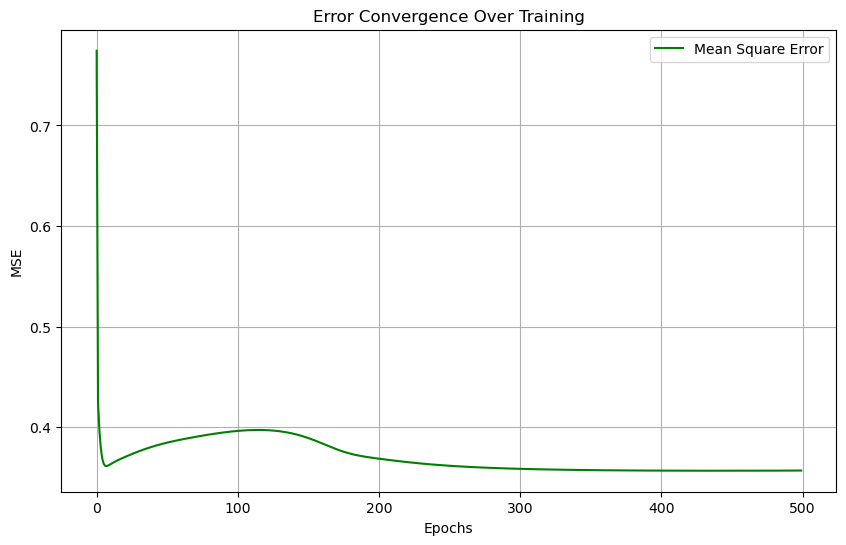

In [6]:
import random
import math
import matplotlib.pyplot as plt

# Sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Linear activation function
def linear(x):
    return x

def linear_derivative(x):
    return 1

# Initialize weights and biases randomly
def initialize_weights():
    W1 = [[random.uniform(-1, 1) for _ in range(1)] for _ in range(3)]  # 3 neurons in hidden layer
    W2 = [random.uniform(-1, 1) for _ in range(3)]  # Output layer
    b1 = [random.uniform(-1, 1) for _ in range(3)]
    b2 = random.uniform(-1, 1)
    return W1, W2, b1, b2

# Forward propagation
def forward_pass(p, W1, W2, b1, b2):
    z1 = [sigmoid(W1[i][0] * p + b1[i]) for i in range(3)]
    a1 = [linear(W2[i] * z1[i]) for i in range(3)]
    a2 = sum(a1) + b2  # Final output
    return z1, a2

# Backward propagation and weight update
def backpropagation(p, target, W1, W2, b1, b2, learning_rate=0.1):
    # Forward pass
    z1, a2 = forward_pass(p, W1, W2, b1, b2)
    
    # Compute the error
    error = a2 - target
    
    # Backpropagate the error
    dW2 = [error * linear_derivative(a2) * z1[i] for i in range(3)]
    db2 = error * linear_derivative(a2)
    
    dW1 = [[error * linear_derivative(a2) * W2[i] * sigmoid_derivative(z1[i]) * p for i in range(3)] for _ in range(3)]
    db1 = [error * linear_derivative(a2) * W2[i] * sigmoid_derivative(z1[i]) for i in range(3)]
    
    # Update the weights and biases
    for i in range(3):
        W2[i] -= learning_rate * dW2[i]
        b1[i] -= learning_rate * db1[i]
        for j in range(1):
            W1[i][j] -= learning_rate * dW1[i][j]
    b2 -= learning_rate * db2
    
    return W1, W2, b1, b2, error

# Generate training data
def generate_training_data():
    inputs = [i * 0.1 for i in range(-20, 21)]  # Range from -2 to 2
    targets = [1 + math.sin(math.pi * p) for p in inputs]
    return inputs, targets

# Train the neural network
def train_network(iterations=500):
    W1, W2, b1, b2 = initialize_weights()
    inputs, targets = generate_training_data()
    errors = []
    
    for epoch in range(iterations):
        total_error = 0
        for p, target in zip(inputs, targets):
            W1, W2, b1, b2, error = backpropagation(p, target, W1, W2, b1, b2)
            total_error += error ** 2
        errors.append(total_error / len(inputs))
    
    return W1, W2, b1, b2, errors

# Plot the results
def plot_results(W1, W2, b1, b2):
    inputs, targets = generate_training_data()
    outputs = [forward_pass(p, W1, W2, b1, b2)[1] for p in inputs]
    
    plt.figure(figsize=(10, 6))
    plt.plot(inputs, targets, label="Target function $1 + \sin(\pi p)$", color="blue")
    plt.plot(inputs, outputs, label="Neural network approximation", color="red", linestyle="dashed")
    plt.title("Function Approximation using 1-3-1 Neural Network")
    plt.xlabel("p")
    plt.ylabel("g(p)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to run the training and plot results
def main():
    W1, W2, b1, b2, errors = train_network()
    plot_results(W1, W2, b1, b2)
    
    # Plot error convergence
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(errors)), errors, label="Mean Square Error", color="green")
    plt.title("Error Convergence Over Training")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


## Generalization

In most cases, the multilayer network is trained with a finite number of examples of proper network behavior:

$$ \{(p_1, t_1), (p_2, t_2), \dots, (p_Q, t_Q)\}. \tag{11.56} $$

This training set is normally representative of a much larger class of possible input/output pairs. It is important that the network successfully generalizes what it has learned to the total population.

For example, suppose that the training set is obtained by sampling the following function:

$$ g(p) = 1 + \sin \left( \frac{\pi}{4} p \right), \tag{11.57} $$

at the points $ p = -2, -1.6, -1.2, \dots, 1.6, 2 $ (There are a total of 11 input/target pairs). In Figure 11.14, we see the response of a 1-2-1 network that has been trained on this data. The black line represents $ g(p) $, the blue line represents the network response, and the $ + $ symbols indicate the training set.

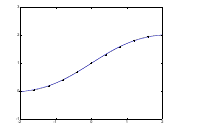

Figure.14 1-2-1 Network Approximation of g(p)

We can see that the network response is an accurate representation of $ g(p) $. If we were to find the response of the network at a value of $ p $ that was not contained in the training set (e.g., $ p = -0.2 $), the network would still produce an output close to $ g(p) $. This network generalizes well.

Now, consider Figure 11.15, which shows the response of a 1-9-1 network that has been trained on the same dataset. Note that the network response accurately models $ g(p) $ at all of the training points. However, if we compute the network response at a value of $ p $ not contained in the training set (e.g., $ p = -0.2 $), the network might produce an output far from the true response $ g(p) $. This network does not generalize well.


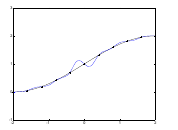

Figure.15 1-9-1 Network Approximation of g ( p )

The 1-9-1 network has too much flexibility for this problem; it has a total of 28 adjustable parameters (18 weights and 10 biases), and yet there are only 11 data points in the training set. The 1-2-1 network has only 7 parameters and is therefore much more restricted in the types of functions that it can implement.

For a network to be able to generalize, it should have fewer parameters than there are data points in the training set. In neural networks, as in all modeling problems, we want to use the simplest network that can adequately represent the training set. Don’t use a bigger network when a smaller network will work (a concept often referred to as **Ockham’s Razor**).

An alternative to using the simplest network is to stop the training before the network overfits. A reference to this procedure and other techniques to improve generalization are given in Chapter 13.





Training 1-2-1 Network...
Training 1-9-1 Network...


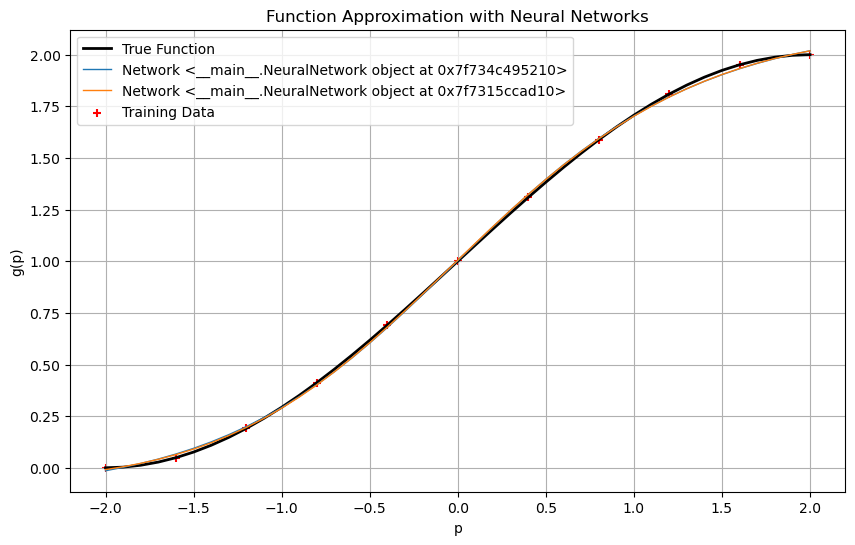

In [7]:
import random
import math
import matplotlib.pyplot as plt

# Define the sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Generate training data based on the function g(p)
def generate_data():
    p_values = [-2 + 0.4 * i for i in range(11)]  # Training points from -2 to 2
    t_values = [1 + math.sin(math.pi / 4 * p) for p in p_values]  # Target values
    return p_values, t_values

# Define a simple neural network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_output = random.uniform(-1, 1)

    def forward(self, inputs):
        # Calculate hidden layer activations
        self.hidden_activations = []
        for i in range(len(self.weights_input_hidden[0])):
            hidden_input = sum(inputs[j] * self.weights_input_hidden[j][i] for j in range(len(inputs))) + self.bias_hidden[i]
            self.hidden_activations.append(sigmoid(hidden_input))

        # Calculate output layer activation
        self.output = sum(self.hidden_activations[i] * self.weights_hidden_output[i] for i in range(len(self.hidden_activations))) + self.bias_output
        return self.output

    def backward(self, inputs, target, learning_rate):
        # Calculate output error and delta
        output_error = target - self.output
        output_delta = output_error  # derivative of linear activation is 1

        # Calculate hidden layer error and delta
        hidden_errors = [output_delta * self.weights_hidden_output[i] for i in range(len(self.hidden_activations))]
        hidden_deltas = [hidden_errors[i] * sigmoid_derivative(self.hidden_activations[i]) for i in range(len(self.hidden_activations))]

        # Update weights and biases
        for i in range(len(self.weights_hidden_output)):
            self.weights_hidden_output[i] += learning_rate * output_delta * self.hidden_activations[i]

        self.bias_output += learning_rate * output_delta

        for i in range(len(self.bias_hidden)):
            self.bias_hidden[i] += learning_rate * hidden_deltas[i]

            for j in range(len(self.weights_input_hidden)):
                self.weights_input_hidden[j][i] += learning_rate * hidden_deltas[i] * inputs[j]

# Train the network
def train_network(network, inputs, targets, epochs, learning_rate):
    for epoch in range(epochs):
        for i in range(len(inputs)):
            network.forward(inputs[i])
            network.backward(inputs[i], targets[i], learning_rate)

# Plotting the results
def plot_results(networks, inputs, targets, true_function):
    plt.figure(figsize=(10, 6))
    
    # Plot true function
    p_range = [-2, 2]
    p_values = [p / 10.0 for p in range(int(p_range[0] * 10), int(p_range[1] * 10) + 1)]
    true_values = [true_function(p) for p in p_values]
    plt.plot(p_values, true_values, label='True Function', color='black', linewidth=2)

    # Plot network responses
    for network in networks:
        outputs = [network.forward([p]) for p in p_values]
        plt.plot(p_values, outputs, label=f'Network {network}', linewidth=1)

    # Plot training data
    plt.scatter(inputs, targets, color='red', marker='+', label='Training Data')
    plt.title('Function Approximation with Neural Networks')
    plt.xlabel('p')
    plt.ylabel('g(p)')
    plt.legend()
    plt.grid()
    plt.show()

# Define the true function
def true_function(p):
    return 1 + math.sin(math.pi / 4 * p)

# Main function to execute training and visualization
def main():
    # Generate training data
    inputs, targets = generate_data()

    # Create two networks with different architectures
    network_1_2_1 = NeuralNetwork(input_size=1, hidden_size=2, output_size=1)
    network_1_9_1 = NeuralNetwork(input_size=1, hidden_size=9, output_size=1)

    # Train both networks
    epochs = 10000
    learning_rate = 0.01

    print("Training 1-2-1 Network...")
    for _ in range(epochs):
        for i in range(len(inputs)):
            network_1_2_1.forward([inputs[i]])
            network_1_2_1.backward([inputs[i]], targets[i], learning_rate)

    print("Training 1-9-1 Network...")
    for _ in range(epochs):
        for i in range(len(inputs)):
            network_1_9_1.forward([inputs[i]])
            network_1_9_1.backward([inputs[i]], targets[i], learning_rate)

    # Plot results
    plot_results([network_1_2_1, network_1_9_1], inputs, targets, true_function)

if __name__ == "__main__":
    main()


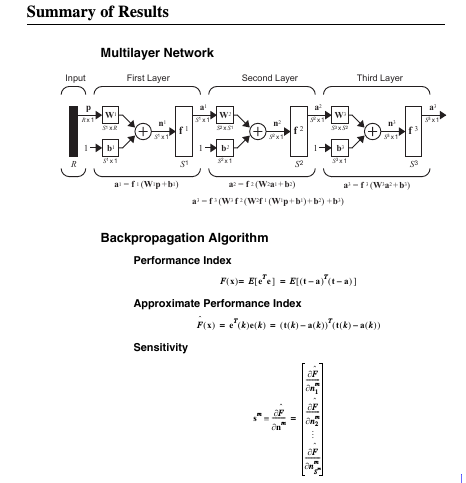

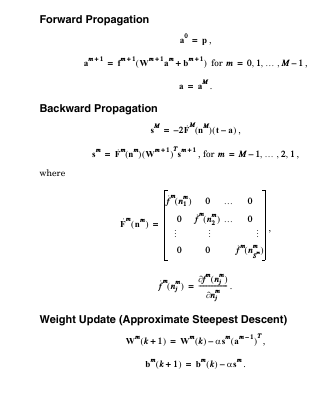

